# Molecular Dynamics Simulation and Analysis in a Notebook

Python is the perfect glue language, with big emphasis on readability and an awesome ecosystem of packages for all kind of areas, ranging from web development or machine learning to the most interesting science. In this short tutorial, we will focus on molecular dynamics as provided by the [Omnia](http://www.omnia.md) project.

Omnia is a compilation of diverse packages for chemistry simulations, but its main pillar is [OpenMM](http://openmm.org/): “a toolkit for molecular simulation using high performance GPU code”. While written in C++/CUDA/OpenCL, it also offers rich APIs in Python. A good number of several other packages use OpenMM or provide additional functionalities, such as [pdbfixer](https://github.com/pandegroup/pdbfixer) (preparation and cleaning), [mdtraj](http://mdtraj.org/1.8.0/) or [pytraj](https://amber-md.github.io/pytraj/) (analysis), [nglview](http://arose.github.io/nglview/latest/) (visualization), [parmed](http://parmed.github.io/ParmEd/html/index.html) (converters between different MD programs) or [openmoltools](https://github.com/choderalab/openmoltools) (a bit of everything, actually).

We will use all of them at some point of the tutorial, outlined here:

**Part A**

1. Prepare an environment for MDs with conda
2. Download, clean and prepare structures from PDB
3. Set up an OpenMM MD simulation from scratch

**Part B**

1. Preview the MD movie in the notebook with nglview
2. MD Analysis with pytraj or mdtraj
3. Custom clustering with the scipy stack

----------------

# A.1 - Prepare the environment

First, create a new Python 3.6 environment (with IPython & Jupyter Notebooks) and name it freely (`-n openmm`, in this case).

```
conda create -n openmm python=3.6 nomkl ipython jupyter notebook
conda activate openmm
```

Then, you can start your own notebook by running `jupyter notebook`. But before... 

The following packages will be required along the tutorial:

- openmm
- mdtraj
- pdbfixer
- nglview
- parmed
- openmoltools

However, they are not provided in the standard `conda` channels like `numpy` or `ipython`. They are hosted in the `omnia` channel, so we need to specify that with the `-c` switch:

```
conda install  -c omnia openmm mdtraj pdbfixer parmed openmoltools
```

`nglview` is not up-to-date in the omnia channel, but it is in `bioconda`:

```
conda install -c bioconda nglview
# only if it does not work
jupyter-nbextension enable nglview --py --user 
```

That's it! Now, try to import this packages to test if they are correctly installed.

In [ ]:
!conda install -y -c omnia openmm mdtraj pdbfixer parmed openmoltools

In [7]:
!conda install -y -c conda-forge -c bioconda nglview ipywidgets

Solving environment: done

## Package Plan ##

  environment location: /home/masterbio/miniconda3/envs/openmm

  added / updated specs: 
    - ipywidgets
    - nglview


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    nglview-1.0                |           py36_1         4.5 MB  conda-forge

The following packages will be UPDATED:

    nglview: 1.0-py36_1 bioconda --> 1.0-py36_1 conda-forge


nglview 1.0: ########################################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


# A.2 - Download and prepare your structure

_Disclaimer: This tutorial is not meant as a MD crash course, but as an exercise to play with Python capabilities in science. Hence, I am not trying to be very cautious about the MD simulation itself. We will use small structures that will allow us to progress rapidly with a modest computer. Remember, we don't care about the MD, only the setup process!_

To run a proper MD, we need to download the structure from some place (PDB, for example), but that's only the first step. Sometimes, the structures are not complete, or include wrong residue names. Some include non-natural residues! Depending on the origin of the files, hydrogens must be added, and depending on which kind of simulation we want to run, we might need to solvate the structure (ie, surround the molecule with a box of waters). While that can be easily attained with Chimera or another GUI programs, we are going to use Python tools... Just because.

Another benefit of learning this procedure is that you could automatize the same pipeline for hundreds of files... :)

So... First! Download the structure.

`1RFO` is a trimer. Let's suppose we only want to run the MD with one of the monomers... Let's pass the `parmed Structure` to `mdtraj`, which features a handy selection language.

In [1]:
import mdtraj as md
trimer = md.load_pdb('http://www.rcsb.org/pdb/files/1RFO.pdb')
trimer.topology # evaluate to obtain relevant info

/home/masterbio/miniconda3/envs/openmm/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


<mdtraj.Topology with 3 chains, 81 residues, 1296 atoms, 1314 bonds at 0x7f56a80e9b38>

In [ ]:
ThisIsAClass
this_is_a_function

In [2]:
import nglview as nv
nv.show_mdtraj(trimer)

NGLWidget(count=10)

In [5]:
# Select only the first chain
indices = trimer.topology.select('chainid 0')
monomer = trimer.atom_slice(indices)

In [8]:
trimer

<mdtraj.Trajectory with 10 frames, 1296 atoms, 81 residues, without unitcells at 0x7f56c069a8d0>

In [6]:
monomer

<mdtraj.Trajectory with 10 frames, 432 atoms, 27 residues, without unitcells at 0x7f569915b240>

In [9]:
# Check everything is OK
import nglview as nv
nv.show_mdtraj(monomer)

NGLWidget(count=10)

In [55]:
# Do we have hydrogens already?
monomer.top.select('element H')

array([  4,   5,   6,   7,   8,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  56,
        57,  58,  59,  60,  61,  62,  72,  73,  74,  75,  76,  77,  83,
        84,  85,  86,  87,  95,  96,  97,  98,  99, 100, 101, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 134, 135,
       136, 137, 142, 143, 144, 154, 155, 156, 157, 158, 159, 160, 161,
       167, 168, 169, 170, 171, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 200, 201, 202, 203, 204, 205, 206, 207, 208, 220, 221, 222,
       223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 242, 243, 244,
       245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 263, 264, 265,
       266, 271, 272, 273, 283, 284, 285, 286, 287, 288, 303, 304, 305,
       306, 307, 308, 309, 310, 311, 312, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346,
       347, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 36

So far, so good. Looks like the structure is ready! If it weren't, `pdbfixer` could be applied.

# A.3 - Set up an openMM calculation!

The `mdtraj` objects contain all the necessary information about the molecule we need: the topology and its coordinates. We only need to choose a forcefield and then some technical details of the simulation itself.

In [10]:
from simtk import unit
import simtk.openmm as mm
from simtk.openmm import app
from sys import stdout

# Molecule details - atoms, connectivity and positions
topology = monomer.top.to_openmm()
positions = monomer.xyz[0] # we only want the first 'frame' of the molecule; ie, one of the NMR models

# Simulation details - the 'rules' of the game
forcefield = app.ForceField('amber99sbildn.xml', 'amber99_obc.xml')
system = forcefield.createSystem(topology, nonbondedMethod=app.CutoffNonPeriodic)

In [11]:
integrator = mm.LangevinIntegrator(300*unit.kelvin, 
                                   1.0/unit.picoseconds, 
                                   1.0*unit.femtoseconds)
simulation = app.Simulation(topology, system, integrator)

print('Setting initial positions')
simulation.context.setPositions(positions)

print('Minimizing...')
simulation.minimizeEnergy()

Setting initial positions
Minimizing...


In [12]:
# What kind of info do we want back?
simulation.reporters.append(app.DCDReporter('trajectory_.dcd', 1000)) # the movie file
# some realtime data on the progress of the sim
simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, progress=True, remainingTime=True, 
    speed=True, totalSteps=1e5, separator='\t'))
# Assign random but coherent vels
simulation.context.setVelocitiesToTemperature(300*unit.kelvin) 

# Run the thing alrady!
simulation.step(1e5)

#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"	"Time Remaining"
1.0%	1000	-4027.71918536094	270.6426166591805	0	--
2.0%	2000	-3847.12372353673	267.81176152521937	92.7	1:31
3.0%	3000	-3709.751856163144	311.9099515087485	92.2	1:30
4.0%	4000	-3628.158299411647	306.9418460893456	92.1	1:30
5.0%	5000	-3684.2625932563096	319.91842367103607	92.4	1:28
6.0%	6000	-3742.914219290018	311.6984084817746	92.6	1:27
7.0%	7000	-3803.5789091941842	319.11093864813273	92.8	1:26
8.0%	8000	-3722.3563248929568	302.85481433573665	92.6	1:25
9.0%	9000	-3812.5438904366456	321.156331551849	92.8	1:24
10.0%	10000	-3600.651781849563	299.0200403499887	93.1	1:23
11.0%	11000	-3710.7838138174266	284.58366294295394	93.3	1:22
12.0%	12000	-3784.874087117729	288.53727036483207	93.5	1:21
13.0%	13000	-3715.438014317304	293.8687623773479	93.7	1:20
14.0%	14000	-3801.537218749523	318.75396750167533	93.8	1:19
15.0%	15000	-3742.0752215869725	314.90508081221725	94.1	1:18
16.0%	16000	-3594.42254

In [13]:
# Did we got it right?
traj = md.load_dcd('trajectory_.dcd', top=monomer.top)
nv.show_mdtraj(traj)

NGLWidget(count=99)

In [16]:
# Export PDB traj for VMD visualization
traj.save_pdb('trajectory.pdb')

# Trajectory analysis

In [21]:
rmsds = md.rmsd(traj, traj)

In [22]:
rmsds

array([0.        , 0.1126716 , 0.16392724, 0.17311181, 0.1977942 ,
       0.19824512, 0.2086288 , 0.20627648, 0.19662178, 0.23100545,
       0.23041387, 0.2209584 , 0.22186293, 0.25258598, 0.26463863,
       0.24316356, 0.258675  , 0.25382164, 0.22148307, 0.20142841,
       0.22140425, 0.24603117, 0.22830006, 0.22429654, 0.19343536,
       0.19145828, 0.2083157 , 0.21061206, 0.2047941 , 0.2047765 ,
       0.23454975, 0.23043749, 0.24596684, 0.25227228, 0.2411035 ,
       0.24782436, 0.22821774, 0.22865933, 0.23447746, 0.23991011,
       0.24966691, 0.25717574, 0.24726102, 0.24728273, 0.29148883,
       0.31454432, 0.3222001 , 0.3200133 , 0.29265586, 0.24459563,
       0.23088248, 0.22461441, 0.21586393, 0.2424659 , 0.27410272,
       0.28382057, 0.28858677, 0.29188722, 0.2829089 , 0.29705888,
       0.32565254, 0.3035188 , 0.27205908, 0.28298554, 0.2909712 ,
       0.29684526, 0.2920375 , 0.29469973, 0.2955531 , 0.30800143,
       0.30494058, 0.31315532, 0.3271433 , 0.30163354, 0.28395

In [23]:
!conda install -y matplotlib

Solving environment: done

## Package Plan ##

  environment location: /home/masterbio/miniconda3/envs/openmm

  added / updated specs: 
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    matplotlib-2.1.2           |   py36h0e671d2_0         6.7 MB
    pyparsing-2.2.0            |   py36hee85983_1          96 KB
    cycler-0.10.0              |   py36h93f1223_0          13 KB
    ------------------------------------------------------------
                                           Total:         6.8 MB

The following NEW packages will be INSTALLED:

    cycler:          0.10.0-py36h93f1223_0            
    matplotlib:      2.1.2-py36h0e671d2_0             
    pyparsing:       2.2.0-py36hee85983_1             

The following packages will be UPDATED:

    certifi:         2017.11.5-py36_0      conda-forge --> 2018.1.18-py36_0     
    openssl:         1.0.2n-0          

In [24]:
from matplotlib import pyplot as plt

/home/masterbio/miniconda3/envs/openmm/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [25]:
%matplotlib notebook

<IPython.core.display.Javascript object>


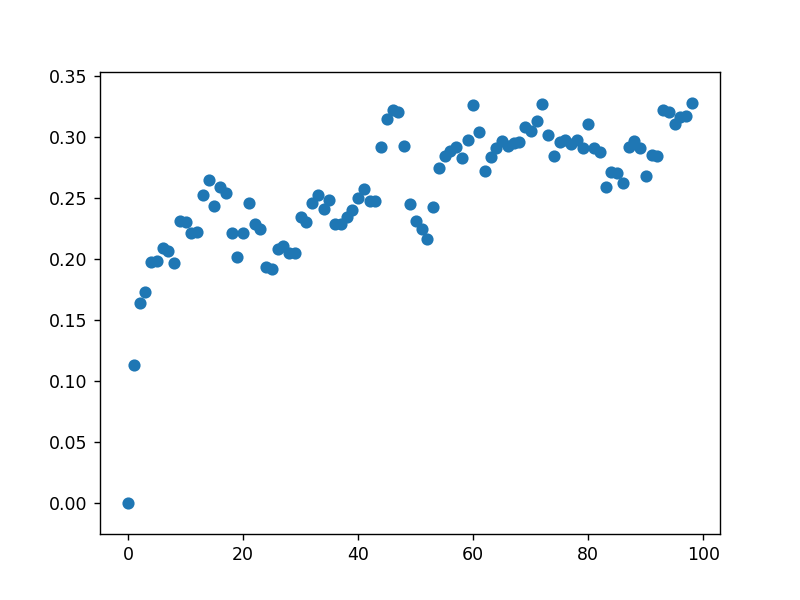

In [29]:
plt.scatter(range(traj.n_frames), rmsds)